# **Analyzing a Reddit-Style Dataset Using WIBA API and `delibtools`**

This notebook provides an end-to-end walkthrough for transforming a dataset of Reddit-style posts using the WIBA API for argument detection and stance analysis, followed by `delibtools` for calculating deliberation intensity.


### **1. Setup**

Start by installing the required libraries:


In [1]:
!pip install delibtools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 5.5 MB/s eta 0:00:00


### **2. Import Required Libraries**


In [2]:
import requests
import pandas as pd
from delibtools import DeliberationIntensity, utils
import json

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Base URL for the WIBA API

In [3]:
BASE_URL = 'http://wiba.dev/api'


### **3. Example Dataset**

We'll create a sample dataset containing 20 Reddit-style posts across three threads.

Alternatively, import your own dataset and check for correct column names

In [4]:
data = {
    'id': [f'{i}' for i in range(1, 22)],
    'parent_id': [None, 't1_1', 't1_1', 't1_1', None, 't1_5', 't1_5', None, 't1_8', 't1_8', None, 't1_11', 't1_11', None, 't1_14', 't1_14', None, 't1_17', 't1_17', 't1_17', 't1_20'],
    # 'thread_id': ['1', '1', '1', '1', '5', '5', '5', '8', '8', '8', '11', '11', '11', '14', '14', '14', '17', '17', '17', '17', '17'],
    'text': [
        # Thread 1
        "I strongly believe that this new policy will significantly reduce pollution in urban areas. Not only does it introduce more stringent regulations on industrial emissions, but it also promotes the adoption of green technologies in both public and private sectors. This is critical, as urban centers have long struggled with poor air quality due to vehicular and industrial emissions. By setting higher standards for emissions and offering incentives for green initiatives, the policy provides a comprehensive solution. It's not just about cutting emissions but also about fostering innovation in green tech. Additionally, the policy includes a long-term roadmap for monitoring and ensuring compliance, which is essential for its success over the coming decades.",
        "While the goal of reducing pollution is certainly commendable, I'm concerned that this policy might have unintended economic consequences. The costs associated with implementing these new regulations could be enormous, particularly for smaller businesses that may struggle to meet the new standards. In the short term, this could lead to increased costs for consumers, as businesses pass on the extra expenses. Moreover, there's a risk that some industries may relocate to regions with less stringent regulations, which would not only harm the local economy but also fail to achieve the policy's primary environmental goals. I'm also skeptical about the timeline for seeing meaningful improvements in air quality, given how complex and entrenched the problem is.",
        "I understand the concerns about economic costs, but I believe the long-term benefits far outweigh the short-term challenges. In the case of small businesses, the policy has provisions for subsidies and grants to help them transition to greener technologies. Moreover, we've seen from other case studies, such as the transition to renewable energy in certain parts of Europe, that once these systems are in place, they lead to cost savings and economic growth. Industries might indeed face challenges initially, but as green technologies become more widespread and affordable, the overall cost of compliance will decrease. I think it's important to focus on the bigger picture — cleaner air, improved public health, and long-term sustainability.",
        "I completely agree with you on the long-term perspective. It's easy to get caught up in the short-term costs, but we have to consider the health impacts of doing nothing. Chronic respiratory diseases, higher healthcare costs, and loss of productivity are all associated with high pollution levels, particularly in urban areas. This policy could lead to significant reductions in these health costs over time. Furthermore, investing in green technologies now could give our economy a competitive edge in the future global market, where sustainability is becoming an increasingly important factor. The policy isn’t perfect, but it’s a strong step in the right direction, provided the government stays committed to supporting industries during the transition.",

        # Thread 2
        "The new law aimed at improving education outcomes is a much-needed reform in our current system. By allocating more resources to underfunded schools and creating more rigorous academic standards, this law could help bridge the gap between high-performing and low-performing schools. What stands out to me is the emphasis on teacher training, which has been neglected for too long. Teachers play a pivotal role in shaping students’ futures, and improving the quality of teacher training could have a ripple effect on student outcomes. Furthermore, the law includes mechanisms for regularly reviewing and updating curricula to ensure they remain relevant in a rapidly changing world. However, I am curious about how this law will affect existing schools that are already meeting high standards.",
        "While I agree that improving education is essential, I have reservations about how effective this law will be in practice. One of my main concerns is the focus on standardized testing, which this law still emphasizes. In my opinion, standardized tests often fail to capture the full range of student abilities and can place undue stress on both students and teachers. Moreover, the additional resources provided to underperforming schools are welcomed, but I fear they may not be enough to make a real difference. We've seen similar policies in the past where funding was promised but either failed to materialize or was insufficient to tackle the systemic issues plaguing these schools. Additionally, I wonder if there's enough flexibility in this law to allow schools to innovate and adopt new teaching methods tailored to their students' needs.",
        "The city’s new traffic management plan has sparked a lot of debate, and for good reason. While I appreciate the intent behind it — reducing congestion, improving safety for pedestrians and cyclists, and lowering carbon emissions — I feel that it doesn’t fully address the city’s unique challenges. The addition of bike lanes is certainly a positive step, but the way they’re being implemented seems rushed and poorly planned. In some areas, bike lanes have replaced entire car lanes, leading to even more congestion during peak hours. There’s also the issue of enforcement. Without proper monitoring, cars often park illegally in bike lanes, defeating their purpose entirely. The plan could have been more effective if it focused more on public transportation and less on restricting car usage.",

        # Thread 3
        "The city's traffic management plan is flawed. Bike lanes are causing more congestion.",
        "While the bike lanes cause issues, they are a step toward making the city more bike-friendly.",
        "We need better planning and enforcement, but I agree this plan is a step in the right direction.",

        # Additional arguments
        "Public transportation should be improved instead of adding more bike lanes.",
        "Subsidizing small businesses to comply with environmental policies is essential.",
        "Teacher training reforms will have the most significant impact on education.",
        "I don’t think the policy will reduce emissions fast enough to meet climate goals.",
        "Banning cars from the city center is a more effective way to tackle congestion.",
        "Encouraging carpooling would also reduce traffic, not just more bike lanes.",
        "The education reform law should focus on reducing class sizes as well.",
        "Funding for renewable energy should be prioritized over short-term economic costs.",
        "Tax incentives for green technologies are a more practical solution.",
        "Road pricing would better address congestion than just adding bike lanes.",
        "More public awareness campaigns are needed to support these environmental policies."
    ]
}

df = pd.DataFrame(data)
df.head()


,id,parent_id,text
0,1,None,I strongly believe that this new policy will s...
1,2,t1_1,While the goal of reducing pollution is certai...
2,3,t1_1,I understand the concerns about economic costs...
3,4,t1_1,I completely agree with you on the long-term p...
4,5,None,The new law aimed at improving education outco...


### **4. Using WIBA API**

#### **4.0. Creating Text Segments** (Optional)
The `create_segments` endpoint allows you to break long arguments into smaller parts, which is useful for applying argument detection and stance analysis on segments of a larger text.

In [5]:

def create_segments(input_file, column_name, window_size=3):
    """
    Create text segments using the API's create_segments endpoint.

    Args:
        input_file (str): CSV file content as a string.
        column_name (str): Name of the column containing text to segment.
        window_size (int, optional): Size of the sliding window. Defaults to 3.

    Returns:
        pandas.DataFrame: Created segments.
    """
    url = f"{BASE_URL}/create_segments"
    payload = {
        "data": input_file,
        "column_name": column_name,
        "window_size": window_size,
        "step_size": 1
    }
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        result_csv = response.json()
        segments_df = pd.DataFrame(result_csv)
        print("Created segments:")
        return segments_df
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None


# Convert DataFrame to CSV format
csv_data = df.to_csv(index=False)

# Call the 'create_segments' API endpoint
create_segments_df = create_segments(csv_data, "text", window_size=3)

# Display the created segments
create_segments_df

Created segments:


,id,parent_id,text,original_id,processed_text,text_segment,start_index,end_index
0,1,None,I strongly believe that this new policy will s...,0,i strongly believe that this new policy will s...,i strongly believe that this new policy will s...,0,2
1,1,None,I strongly believe that this new policy will s...,0,i strongly believe that this new policy will s...,not only does it introduce more stringent regu...,1,3
2,1,None,I strongly believe that this new policy will s...,0,i strongly believe that this new policy will s...,"this is critical, as urban centers have long s...",2,4
3,1,None,I strongly believe that this new policy will s...,0,i strongly believe that this new policy will s...,by setting higher standards for emissions and ...,3,5
4,2,t1_1,While the goal of reducing pollution is certai...,1,while the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,0,2
5,2,t1_1,While the goal of reducing pollution is certai...,1,while the goal of reducing pollution is certai...,the costs associated with implementing these n...,1,3
6,2,t1_1,While the goal of reducing pollution is certai...,1,while the goal of reducing pollution is certai...,"in the short term, this could lead to increase...",2,4
7,3,t1_1,I understand the concerns about economic costs...,2,i understand the concerns about economic costs...,i understand the concerns about economic costs...,0,2
8,3,t1_1,I understand the concerns about economic costs...,2,i understand the concerns about economic costs...,"in the case of small businesses, the policy ha...",1,3
9,3,t1_1,I understand the concerns about economic costs...,2,i understand the concerns about economic costs...,"moreover, we've seen from other case studies, ...",2,4


#### **4.1. Detecting Arguments**

We’ll first detect arguments in each of the posts using the `wiba_detect` function. The function sends the data to the WIBA API’s `/detect` endpoint and returns the detected arguments.


In [6]:
def wiba_detect(df):
    url = 'http://wiba.dev/api/detect'
    csv_data = df.to_csv(index=False)
    payload = {"texts": csv_data}
    response = requests.post(url, json=payload)
    return pd.DataFrame(response.json())

# Detect arguments in the dataset
detect_df = wiba_detect(create_segments_df)
detect_df

,id,parent_id,text,original_id,processed_text,text_segment,start_index,end_index,argument_prediction,argument_confidence
0,1,None,I strongly believe that this new policy will s...,0,i strongly believe that this new policy will s...,i strongly believe that this new policy will s...,0,2,Argument,0.927734
1,1,None,I strongly believe that this new policy will s...,0,i strongly believe that this new policy will s...,not only does it introduce more stringent regu...,1,3,Argument,0.927734
2,1,None,I strongly believe that this new policy will s...,0,i strongly believe that this new policy will s...,"this is critical, as urban centers have long s...",2,4,Argument,0.927734
3,1,None,I strongly believe that this new policy will s...,0,i strongly believe that this new policy will s...,by setting higher standards for emissions and ...,3,5,Argument,0.927734
4,2,t1_1,While the goal of reducing pollution is certai...,1,while the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,0,2,Argument,0.920898
5,2,t1_1,While the goal of reducing pollution is certai...,1,while the goal of reducing pollution is certai...,the costs associated with implementing these n...,1,3,Argument,0.920898
6,2,t1_1,While the goal of reducing pollution is certai...,1,while the goal of reducing pollution is certai...,"in the short term, this could lead to increase...",2,4,Argument,0.920898
7,3,t1_1,I understand the concerns about economic costs...,2,i understand the concerns about economic costs...,i understand the concerns about economic costs...,0,2,Argument,0.932617
8,3,t1_1,I understand the concerns about economic costs...,2,i understand the concerns about economic costs...,"in the case of small businesses, the policy ha...",1,3,Argument,0.932617
9,3,t1_1,I understand the concerns about economic costs...,2,i understand the concerns about economic costs...,"moreover, we've seen from other case studies, ...",2,4,Argument,0.932617


#### **4.1.1 Calculating Arguments**

Now that we've identified the arguments within a block of text, we want to select the most likely span of text that consists of an argument. The function sends the data to the WIBA API’s `/calculate_segments` endpoint and returns the segment considered to be the most *confident* argument.


In [7]:
# calculate segments
def calculate_segments(input_file, column_name, confidence_column):
    """
    Calculate segment scores using the API's calculate_segments endpoint.

    Args:
        input_file (str): CSV file content as a string.
        column_name (str): Name of the column containing segments.
        confidence_column (str): Name of the column containing confidence scores.

    Returns:
        pandas.DataFrame: Calculated segment scores.
    """
    url = f"{BASE_URL}/calculate_segments"
    input_file = input_file.to_csv(index=False)
    payload = {
        "data": input_file,
        "segment_column": column_name,
        "argument_score_column": confidence_column
    }
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        result_csv = response.json()
        segments_df = pd.DataFrame(result_csv)
        return segments_df
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

calculate_segments_df = calculate_segments(detect_df, "text_segment", "argument_confidence")
calculate_segments_df

,id,parent_id,original_id,text,processed_text,text_segment,start_index,end_index,argument_prediction,confidence
0,1,None,0,I strongly believe that this new policy will s...,i strongly believe that this new policy will s...,i strongly believe that this new policy will s...,0,2,Argument,0.927734
1,1,None,0,I strongly believe that this new policy will s...,i strongly believe that this new policy will s...,"this is critical, as urban centers have long s...",2,4,Argument,0.927734
2,2,t1_1,1,While the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,0,2,Argument,0.920898
3,2,t1_1,1,While the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,"in the short term, this could lead to increase...",2,4,Argument,0.920898
4,3,t1_1,2,I understand the concerns about economic costs...,i understand the concerns about economic costs...,i understand the concerns about economic costs...,0,2,Argument,0.932617
5,3,t1_1,2,I understand the concerns about economic costs...,i understand the concerns about economic costs...,"moreover, we've seen from other case studies, ...",2,4,Argument,0.932617
6,4,t1_1,3,I completely agree with you on the long-term p...,i completely agree with you on the long-term p...,i completely agree with you on the long-term p...,0,2,Argument,0.917480
7,4,t1_1,3,I completely agree with you on the long-term p...,i completely agree with you on the long-term p...,"chronic respiratory diseases, higher healthcar...",2,4,Argument,0.917480
8,5,None,4,The new law aimed at improving education outco...,the new law aimed at improving education outco...,the new law aimed at improving education outco...,0,2,Argument,0.859863
9,5,None,4,The new law aimed at improving education outco...,the new law aimed at improving education outco...,what stands out to me is the emphasis on teach...,2,4,Argument,0.858887


#### **4.2. Extracting Topics**

Next, we’ll use the `wiba_extract` function to identify the key topics being discussed in the posts.


In [8]:
def wiba_extract(texts):
    url = 'http://wiba.dev/api/extract'
    payload = {"texts": texts}
    response = requests.post(url, json=payload)
    return pd.DataFrame(response.json())

texts = calculate_segments_df['text_segment'].tolist()
extract_df = wiba_extract(texts)
extract_df = extract_df[['extracted_topic']]

# merge back
extract_df = pd.concat([calculate_segments_df, extract_df], axis=1)
print("Extracted topics:")
extract_df

Extracted topics:


,id,parent_id,original_id,text,processed_text,text_segment,start_index,end_index,argument_prediction,confidence,extracted_topic
0,1,None,0,I strongly believe that this new policy will s...,i strongly believe that this new policy will s...,i strongly believe that this new policy will s...,0,2,Argument,0.927734,urbanization
1,1,None,0,I strongly believe that this new policy will s...,i strongly believe that this new policy will s...,"this is critical, as urban centers have long s...",2,4,Argument,0.927734,urbanization
2,2,t1_1,1,While the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,0,2,Argument,0.920898,climate change policy
3,2,t1_1,1,While the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,"in the short term, this could lead to increase...",2,4,Argument,0.920898,carbon pricing
4,3,t1_1,2,I understand the concerns about economic costs...,i understand the concerns about economic costs...,i understand the concerns about economic costs...,0,2,Argument,0.932617,green technology
5,3,t1_1,2,I understand the concerns about economic costs...,i understand the concerns about economic costs...,"moreover, we've seen from other case studies, ...",2,4,Argument,0.932617,green technology
6,4,t1_1,3,I completely agree with you on the long-term p...,i completely agree with you on the long-term p...,i completely agree with you on the long-term p...,0,2,Argument,0.917480,urbanization
7,4,t1_1,3,I completely agree with you on the long-term p...,i completely agree with you on the long-term p...,"chronic respiratory diseases, higher healthcar...",2,4,Argument,0.917480,green technology
8,5,None,4,The new law aimed at improving education outco...,the new law aimed at improving education outco...,the new law aimed at improving education outco...,0,2,Argument,0.859863,teacher tenure law
9,5,None,4,The new law aimed at improving education outco...,the new law aimed at improving education outco...,what stands out to me is the emphasis on teach...,2,4,Argument,0.858887,teacher training


#### **4.3. Analyzing Stance**

Finally, we’ll analyze the stance of each post regarding the extracted topics using the `wiba_stance` function.


In [9]:
def wiba_stance(texts, topics):
    url = 'http://wiba.dev/api/stance'
    payload = {"texts": texts, "topics": topics}
    response = requests.post(url, json=payload)
    return pd.DataFrame(response.json())

# Extract topics and analyze stance
extract_df = extract_df.rename(columns={"extracted_topic": "topic"})
topics = extract_df['topic'].tolist()
stance_df = wiba_stance(texts, topics)
# merge back
stance_df = pd.concat([extract_df, stance_df], axis=1)
print("Stance analysis:")
stance_df

Stance analysis:


,id,parent_id,original_id,text,processed_text,text_segment,start_index,end_index,argument_prediction,confidence,topic,stance_prediction
0,1,None,0,I strongly believe that this new policy will s...,i strongly believe that this new policy will s...,i strongly believe that this new policy will s...,0,2,Argument,0.927734,urbanization,Argument in Favor
1,1,None,0,I strongly believe that this new policy will s...,i strongly believe that this new policy will s...,"this is critical, as urban centers have long s...",2,4,Argument,0.927734,urbanization,Argument in Favor
2,2,t1_1,1,While the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,0,2,Argument,0.920898,climate change policy,Argument Against
3,2,t1_1,1,While the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,"in the short term, this could lead to increase...",2,4,Argument,0.920898,carbon pricing,Argument Against
4,3,t1_1,2,I understand the concerns about economic costs...,i understand the concerns about economic costs...,i understand the concerns about economic costs...,0,2,Argument,0.932617,green technology,Argument in Favor
5,3,t1_1,2,I understand the concerns about economic costs...,i understand the concerns about economic costs...,"moreover, we've seen from other case studies, ...",2,4,Argument,0.932617,green technology,Argument in Favor
6,4,t1_1,3,I completely agree with you on the long-term p...,i completely agree with you on the long-term p...,i completely agree with you on the long-term p...,0,2,Argument,0.917480,urbanization,Argument in Favor
7,4,t1_1,3,I completely agree with you on the long-term p...,i completely agree with you on the long-term p...,"chronic respiratory diseases, higher healthcar...",2,4,Argument,0.917480,green technology,Argument in Favor
8,5,None,4,The new law aimed at improving education outco...,the new law aimed at improving education outco...,the new law aimed at improving education outco...,0,2,Argument,0.859863,teacher tenure law,Argument in Favor
9,5,None,4,The new law aimed at improving education outco...,the new law aimed at improving education outco...,what stands out to me is the emphasis on teach...,2,4,Argument,0.858887,teacher training,Argument in Favor


# DelibTools Example


#### **5.0. Initialize DeliberationIntensity Class**

Set verbose=True for outputting progress bars.


In [10]:
di = DeliberationIntensity(verbose=True,group="thread_id",text='text',argument='argument',id='id',speech='text_segment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### **5.1. Generating Thread IDs**
`The delibtools` package allows for finding and assigning ***Reddit*** posts that are found within the same tree-like structure of a reply-post network to a unique thread id.


In [11]:
# assign author column as "author_id" if an author column is not present already
stance_df['author'] = "author_"+stance_df['id'].astype(str)

stance_df['thread_id'] = utils.assign_reddit_threads(stance_df)
stance_df

Generating thread IDs: 100%|██████████| 29/29 [00:00<00:00, 1621.11it/s]


,id,parent_id,original_id,text,processed_text,text_segment,start_index,end_index,argument_prediction,confidence,topic,stance_prediction,author,thread_id
0,1,None,0,I strongly believe that this new policy will s...,i strongly believe that this new policy will s...,i strongly believe that this new policy will s...,0,2,Argument,0.927734,urbanization,Argument in Favor,author_1,1
1,1,None,0,I strongly believe that this new policy will s...,i strongly believe that this new policy will s...,"this is critical, as urban centers have long s...",2,4,Argument,0.927734,urbanization,Argument in Favor,author_1,1
2,2,t1_1,1,While the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,0,2,Argument,0.920898,climate change policy,Argument Against,author_2,2
3,2,t1_1,1,While the goal of reducing pollution is certai...,while the goal of reducing pollution is certai...,"in the short term, this could lead to increase...",2,4,Argument,0.920898,carbon pricing,Argument Against,author_2,2
4,3,t1_1,2,I understand the concerns about economic costs...,i understand the concerns about economic costs...,i understand the concerns about economic costs...,0,2,Argument,0.932617,green technology,Argument in Favor,author_3,3
5,3,t1_1,2,I understand the concerns about economic costs...,i understand the concerns about economic costs...,"moreover, we've seen from other case studies, ...",2,4,Argument,0.932617,green technology,Argument in Favor,author_3,3
6,4,t1_1,3,I completely agree with you on the long-term p...,i completely agree with you on the long-term p...,i completely agree with you on the long-term p...,0,2,Argument,0.917480,urbanization,Argument in Favor,author_4,4
7,4,t1_1,3,I completely agree with you on the long-term p...,i completely agree with you on the long-term p...,"chronic respiratory diseases, higher healthcar...",2,4,Argument,0.917480,green technology,Argument in Favor,author_4,4
8,5,None,4,The new law aimed at improving education outco...,the new law aimed at improving education outco...,the new law aimed at improving education outco...,0,2,Argument,0.859863,teacher tenure law,Argument in Favor,author_5,5
9,5,None,4,The new law aimed at improving education outco...,the new law aimed at improving education outco...,what stands out to me is the emphasis on teach...,2,4,Argument,0.858887,teacher training,Argument in Favor,author_5,5


#### **5.2. Calculating Deliberation Intensity**

We’ll calculate deliberation intensity on the dataset. The method computes argument density and cluster properties across the Reddit-style threads.

In [12]:
stance_df['argument'] = stance_df['argument_prediction'].map({'Argument': 1, 'NoArgument': 0})
# Calculate deliberation intensity
delib_intensity_df = di.calculate_deliberation_intensity(stance_df)
print("Deliberation Intensity Results:")
delib_intensity_df

Calculating Deliberation Intensity...
Calculating D_Cluster...


Calculating D_Cluster:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:   7%|▋         | 1/14 [00:01<00:25,  1.96s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  14%|█▍        | 2/14 [00:03<00:23,  1.92s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  21%|██▏       | 3/14 [00:05<00:18,  1.64s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  29%|██▊       | 4/14 [00:06<00:14,  1.48s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  36%|███▌      | 5/14 [00:07<00:12,  1.34s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  43%|████▎     | 6/14 [00:08<00:10,  1.30s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  50%|█████     | 7/14 [00:10<00:09,  1.38s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  57%|█████▋    | 8/14 [00:10<00:05,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  64%|██████▍   | 9/14 [00:10<00:03,  1.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  71%|███████▏  | 10/14 [00:10<00:02,  1.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  79%|███████▊  | 11/14 [00:11<00:01,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  86%|████████▌ | 12/14 [00:11<00:00,  2.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster:  93%|█████████▎| 13/14 [00:11<00:00,  3.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating D_Cluster: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Calculating D_Arg...
Calculating argumentativeness...


Processing groups: 100%|██████████| 14/14 [00:00<00:00, 119.00it/s]

Deliberation Intensity Results:


,thread_id,d_cluster,d_arg,sigma_1,sigma_2,num_arguments,num_turns,dis
0,1,0.500000,0.333333,0.546449,0.453551,2,1,0.424408
1,2,0.500000,0.333333,0.546449,0.453551,2,1,0.424408
2,3,0.500000,0.333333,0.546449,0.453551,2,1,0.424408
3,4,0.500000,0.333333,0.546449,0.453551,2,1,0.424408
4,5,0.500000,0.333333,0.546449,0.453551,2,1,0.424408
5,6,0.500000,0.333333,0.546449,0.453551,2,1,0.424408
6,7,0.333333,0.333333,0.565785,0.434215,3,1,0.333333
7,8,1.000000,0.500000,0.500000,0.500000,1,1,0.750000
8,9,1.000000,1.000000,0.500000,0.500000,1,1,1.000000
9,11,1.000000,1.000000,0.500000,0.500000,1,1,1.000000


#### **5.3. Visualizing Deliberation Intensity with ECDF**

We’ll visualize deliberation intensity using an empirical cumulative distribution function (ECDF) plot.

Plotting ECDFs: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


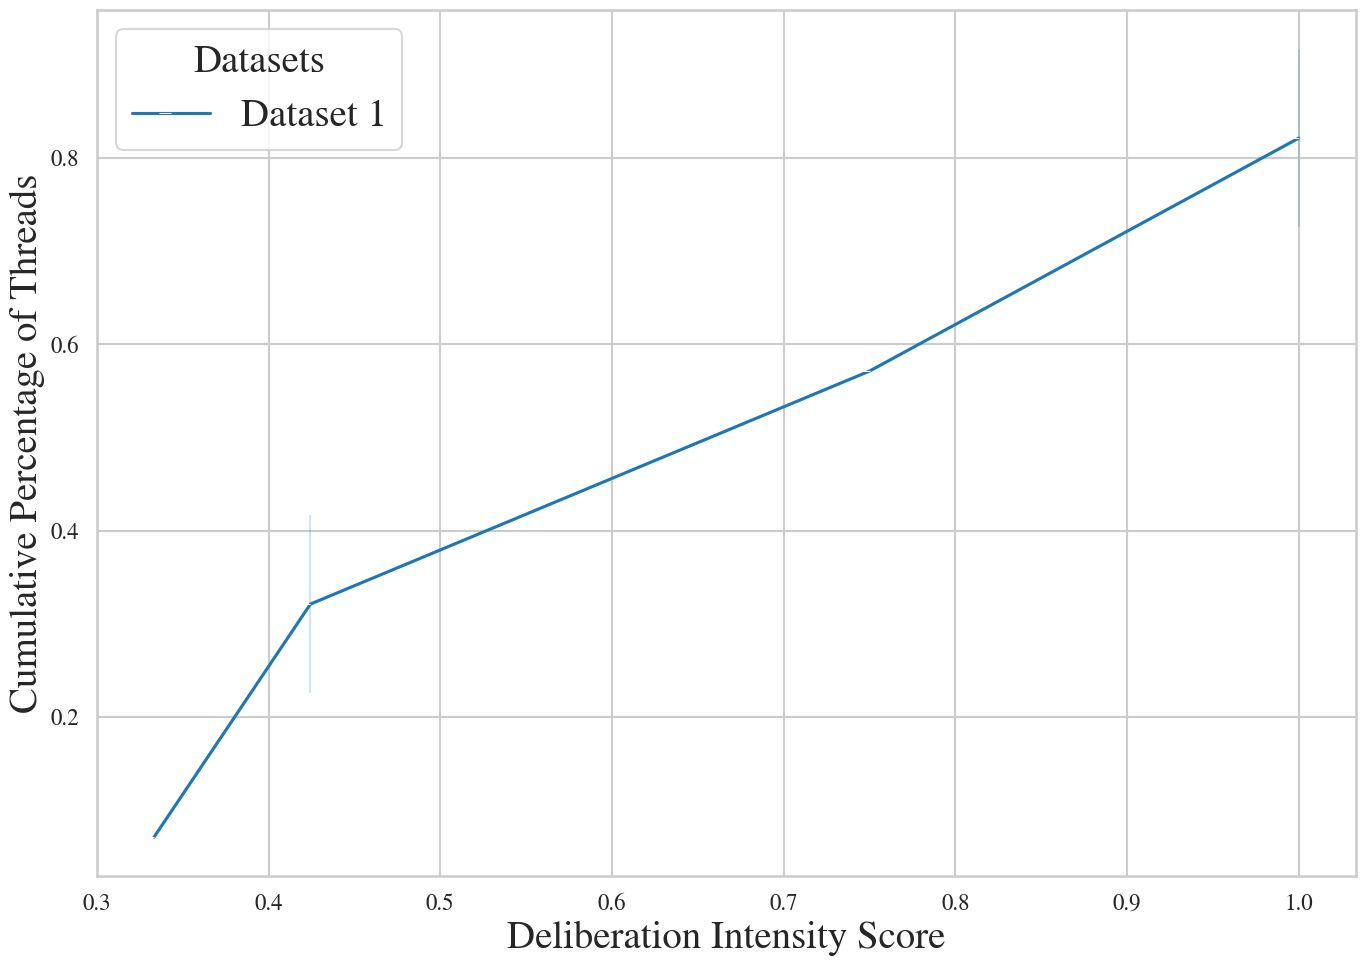

In [13]:
di.plot_ecdf(delib_intensity_df)